# Explainable AI for images

In the previous notebook you've seen that we can explain tabular data by explaining which feature(s) have the most impact on the prediction and in which direction they pull the prediction. We can do this for the entire dataset or for one single prediction. 

In this notebook you will see that we can also explain why a certain image was categorized 

In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor,Compose
from torch.utils.data import DataLoader
from pathlib import Path

First we have to build a model again as input for our SHAP values

In [3]:
datadir = Path("../../data/raw/")

#uncomment to use FashionMNIST
dataset_train = datasets.FashionMNIST(root=datadir, train=True, download=True, transform=ToTensor())
dataset_test = datasets.FashionMNIST(root=datadir, train=False, download=True, transform=ToTensor())

#dataset_train = datasets.MNIST(root=datadir, train=True, download=True, transform=ToTensor())
#dataset_test = datasets.MNIST(root=datadir, train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=True)

X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

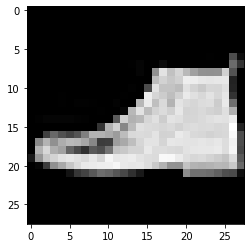

In [4]:
import matplotlib.pyplot as plt
img = X[0]
img.shape
plt.imshow(img.squeeze(), cmap="gray")

In [5]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
                    nn.Conv2d(1, 10, kernel_size=5),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                    nn.Conv2d(10, 20, kernel_size=5),
                    nn.Dropout(),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                )

        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        out = self.fc_layers(x)
        return out

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


In [6]:
import torch.optim as optim
from src.models import metrics
from src.models import train_model
from pathlib import Path

loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

log_dir="../../models/test"


model = train_model.trainloop(
    epochs=10,
    model=model,
    optimizer=optim.Adam,
    learning_rate=1e-2,
    loss_fn=loss_fn,
    metrics=[accuracy],
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    log_dir=log_dir,
    train_steps=50,
    eval_steps=50,
)



2023-01-11 12:48:51.826945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-11 12:48:51.827040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-11 12:48:54.623 | INFO     | src.data.data_tools:dir_add_timestamp:121 - Logging to ../../models/test/20230111-1248
100%|██████████| 50/50 [00:01<00:00, 25.60it/s]
2023-01-11 12:48:57.810 | INFO     | src.models.train_model:trainloop:171 - Epoch 0 train 2.0318 test 1.8733 metric ['0.5884']
100%|██████████| 50/50 [00:01<00:00, 27.26it/s]
2023-01-11 12:49:00.575 | INFO     | src.models.train_model:trainloop:171 - Epoch 1 train 1.8422 test 1.7612 metric ['0.7008']
100%|██████████| 50/50 [00:01<00:00, 27.17it/s]
2023-01-11 12:49:03.326 | INFO     | src.models.train_model:trainloop:171 - Epoch 2 train 

In [7]:
model_dir = Path("../../models") 
modelpath = model_dir / "trained_model"
torch.save(model, modelpath)



Now we have our model, we can start making our explainer. This explainer will show why a certain number/clothing item was classified as it is. First we will select some training examples as background and some test images that we can inspect the SHAP values on.

In [38]:
import shap
import numpy as np

# since shuffle=True, this is a random sample of test data
batch = next(iter(test_dataloader))
images, y = batch

background = images[:120]

#use last 8 images in the batch as the ones to be explained
test_images = images[120:128]
test_y = y[120:128]

#create the explainer using shap.DeepExplainer
explainer = shap.DeepExplainer(model, background)


In [39]:
shap_values = explainer.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


In [44]:
from src.visualization import visualize

# Name each one of the classes
class_names = dataset_train.classes

# Save an example for each category in a dict
images_dict = dict()
for i, l in enumerate(dataset_train.targets):
  if len(images_dict)==10:
    break
  if int(l) not in images_dict.keys():
    images_dict[int(l)] = dataset_train.data[i].reshape((28, 28))

Now we can visualize everything. Run the below cell for the visualization. Some comments what can be understood from this picture:
<ol>
    <li>Positive shap values are denoted by red color and they represent the pixels that contributed to classifying that image as that particular class.</li>
    <li>Negative shap values are denoted by blue color and they represent the pixels that contributed to NOT classify that image as that particular class.</li>
    <li>Each row contains each one of the test images we computed the shap values for.</li>
    <li>Each column represents the ordered categories that the model could choose from. Notice that shap.image_plot just makes a copy of the classified image, but we can use the plot_categories function in src/ created earlier to show an example of that class for reference.</li>
<ol>

tensor([5, 1, 3, 9, 8, 4, 8, 2])


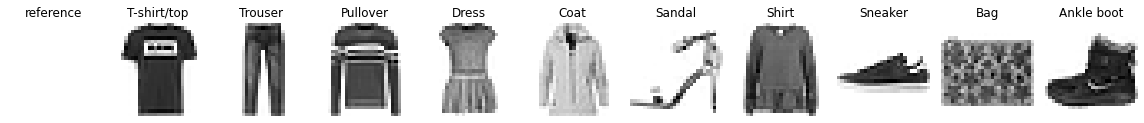

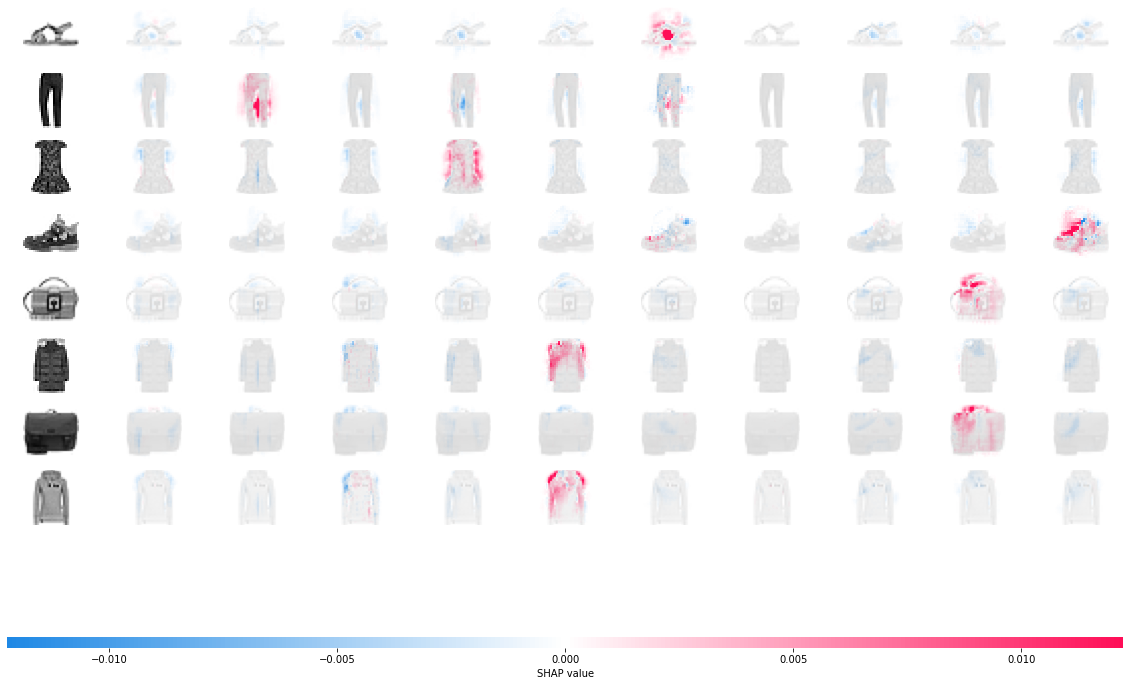

In [45]:
#print the actual classes of the pictures
print(test_y)

#visualize the categories as headers
visualize.plot_categories(images_dict, class_names)

#visualize SHAP 
shap.image_plot(shap_numpy, -test_numpy)